# Predict Scooter Utilization: Data Story
This data story notebook analyzes the data provided by the city of Austin (https://data.austintexas.gov/d/7d8e-dm7r).  The goal is to determine what factors affect ridership.  This notebook examines location, date, day of week, month, and time of day.

## 1. Set up the notebook

In [1]:
'''Change log:
       2019-11-19 TB - Deleted extra columns created by join with centroids
       2019-10-31 TB - Added geographic plots
       2019-10-18 TB 
           -Fixed incorrect comment for hourly counts to say total rather than arbitrary week. 
           -Added missing axis labels
           -Added visualization for section 10.  Time of day by Day of week and Time of day by Census Tract Start
   Pontential changes:
       -Use CDF for trip frequency''';

In [2]:
# Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import geopandas as gpd
from shapely.geometry import LineString

E-Bikes dropped: 338834
Original scooter entries: 6510117
NA rows dropped: 130
Out of Bounds entries dropped: 52981
Before removing outliers:


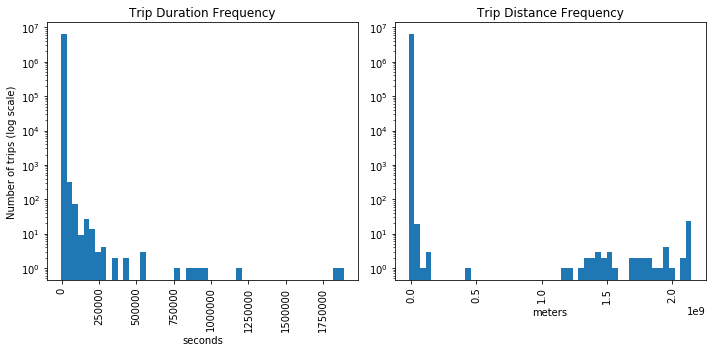

Negative duration dropped: 1028
Over 12.0 hours dropped: 262
Negative or 0 distance dropped: 505391
Distance > 49.9999845312 mi dropped: 965
After removing outliers:


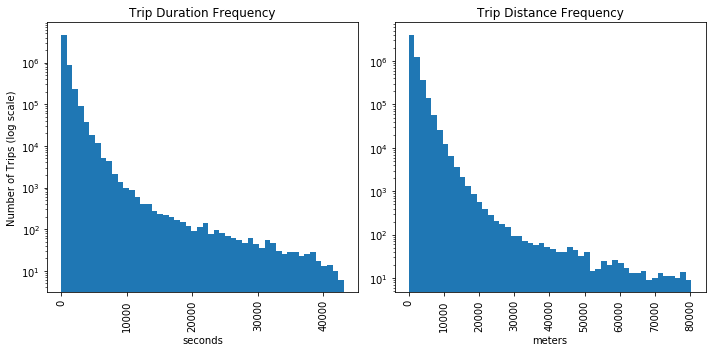

Total entries remaining: 5949360
Percent removed: 8.61362399477613%
Column Data types:
Device ID                           object
Vehicle Type                      category
Trip Duration                      float64
Trip Distance                      float64
Start Time                  datetime64[ns]
End Time                    datetime64[ns]
Modified Date               datetime64[ns]
Month                                 int8
Hour                                  int8
Day of Week                           int8
Council District (Start)           float64
Council District (End)             float64
Year                                 int16
Census Tract Start                  object
Census Tract End                    object
dtype: object


In [3]:
# Import/clean the data.  This is already done in the data_wrangling jupyter_notebook.
%run ./data_wrangling.ipynb

## 2. How long (time or distance) are scooters used?

Data cleaning removed many of the outliers of the data, but it's still difficult to see trends by observing all of the data at once.  If we 'zoom in' to the bulk of the data, more trends in duration and distance can be observed.

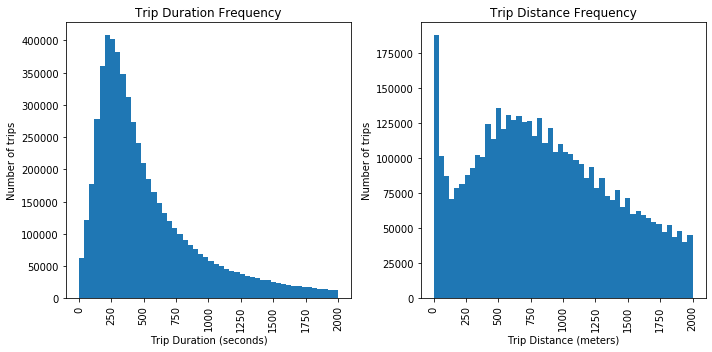

In [4]:
# Plot the histograms from above, with limits on the range
plt.figure(figsize=[10, 5])
plt.subplot(1,2,1)
plt.hist(scooters['Trip Duration'], bins=50, range=(0,2000))
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Number of trips')
plt.title('Trip Duration Frequency')
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
plt.hist(scooters['Trip Distance'], bins=50, range=(0, 2000))
plt.xlabel('Trip Distance (meters)')
plt.ylabel('Number of trips')
plt.title('Trip Distance Frequency')
plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()
plt.close()

Peaks that were otherwise hidden now reveal themselves.  The most rides appear to be be between 250-500 seconds (4-8 min) and 500-750 meters (0.3-0.5 mi). There's also a surprising peak just above 0 m.

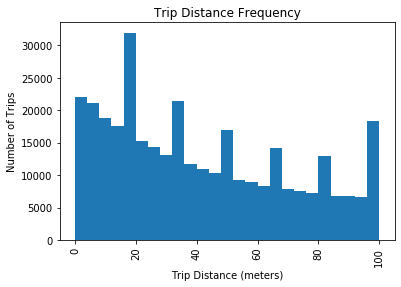

In [5]:
# Plot the 0-50 meters to see if there are any trends within the peak
plt.hist(scooters['Trip Distance'], bins=25, range=(0, 100))
plt.xlabel('Trip Distance (meters)')
plt.ylabel('Number of Trips')
plt.title('Trip Distance Frequency')
plt.xticks(rotation='vertical')

plt.show()
plt.close()

The plot from 0-100m reveals a few regularly placed peaks. These peaks likely result from different rounding practices from the vendors providing data.

## 3. How many Census Tracts are in the data?
This project will use census tracts as a component of the predicted result (i.e. How many scooters should be placed in a certain location at a certain point in time?).  It will be helpful to understand how many unique census tracts exist.

In [6]:
# Use sets to find unique values for each
print('Number of Census Tract Starts: ' + str(len(set(scooters['Census Tract Start']))))
print('Number of Census Tract Ends: ' + str(len(set(scooters['Census Tract End']))))

# Save the unique set of census tracts as a CSV. This will be modified in step 11.
unique_cts = pd.DataFrame(set(scooters['Census Tract End'].append(scooters['Census Tract Start'])))
# unique_cts.to_csv('unique_census_tracts.csv')

# Print number of unique CTs
print('Number of unique Census Tracts in the data: ' + str(len(unique_cts)))

Number of Census Tract Starts: 256
Number of Census Tract Ends: 257
Number of unique Census Tracts in the data: 271


The differences between these 3 values indicates that there are census tracts that have only trip starts or only trip ends.

## 4. Which census tracts have the most traffic?

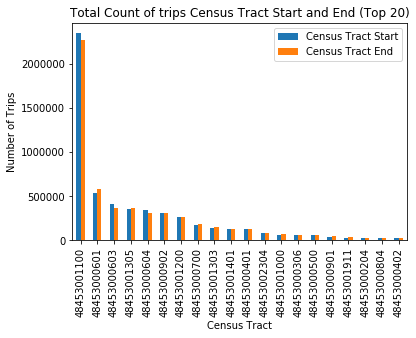

In [7]:
# Count how many trips started in each census tract
census_starts = pd.DataFrame(scooters['Census Tract Start'].value_counts())

# Count how many trips ended in each census tract
census_ends = pd.DataFrame(scooters['Census Tract End'].value_counts())

# Join start and end counts and plot the top 20. Value counts sorts descending, inner join preserves census start's sorting.
census_comp = census_starts.join(census_ends, how='inner')
census_comp.head(20).plot(kind='bar')
plt.title('Total Count of trips Census Tract Start and End (Top 20)')
plt.xlabel('Census Tract')
plt.ylabel('Number of Trips')

plt.show()
plt.close()

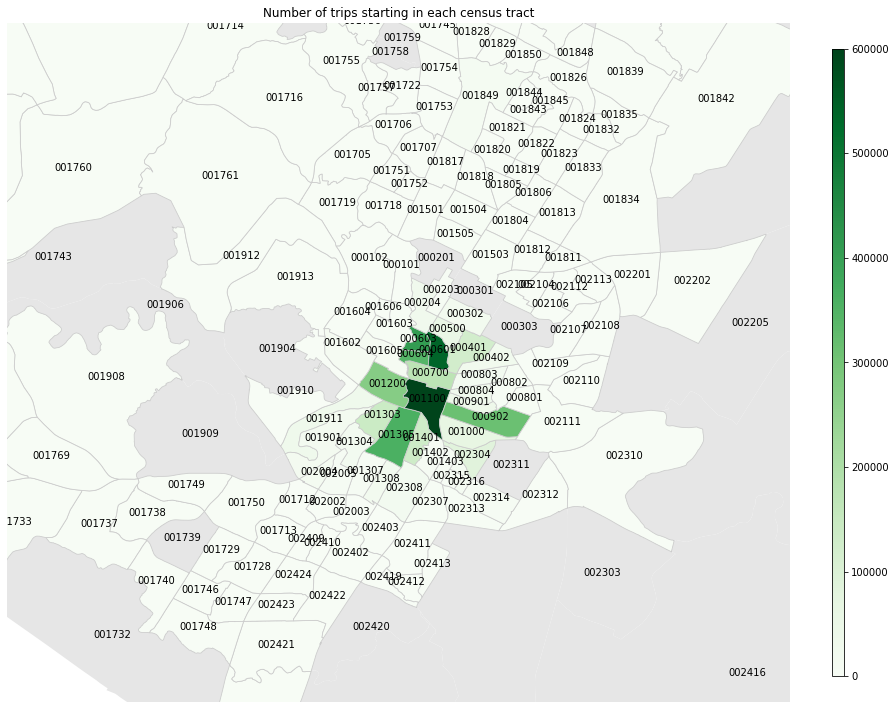

In [8]:
# Plot the census tracts from the US Census Bureau's shapefile using geopandas.
map_df = gpd.read_file('ct data/tl_2010_48453_tract00/tl_2010_48453_tract00.shp')

# Convert the lat/long of the centroids to floats
map_df['INTPTLAT00'] = map_df['INTPTLAT00'].astype('float64')
map_df['INTPTLON00'] = map_df['INTPTLON00'].astype('float64')

## Create a chloropleth of census tract starts
# Plot the data retrieved in the map
ax_start = map_df.plot(color='0.9', figsize=(15, 15))

# Merge the geodataframe with the census starts dataframe
starts_plot = map_df.set_index('CTIDFP00').join(census_starts, how='inner')

# Create a min and max for color
vmax_start = 600000
vmin_start = 0

# Overlay the census tract shapes as a chloropleth
starts_plot.plot(column='Census Tract Start', cmap='Greens', linewidth=0.8, ax=ax_start, edgecolor='0.8', 
                 vmax=vmax_start, vmin=vmin_start)

# Label the census tracts
for idx, row in map_df.iterrows():
    plt.annotate(s=row['TRACTCE00'], xy=(row['INTPTLON00'], row['INTPTLAT00']), horizontalalignment='center', 
                 clip_on=True)


# Set the limits of the plot
bbox = (-97.919881, -97.589348, 30.139918,30.426626)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])

# Remove the axis, add title, and legend
plt.axis('off')
plt.title('Number of trips starting in each census tract')
sm_start = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin_start, vmax=vmax_start))
plt.colorbar(sm_start, fraction=0.015, aspect=50)

plt.show()
plt.close()


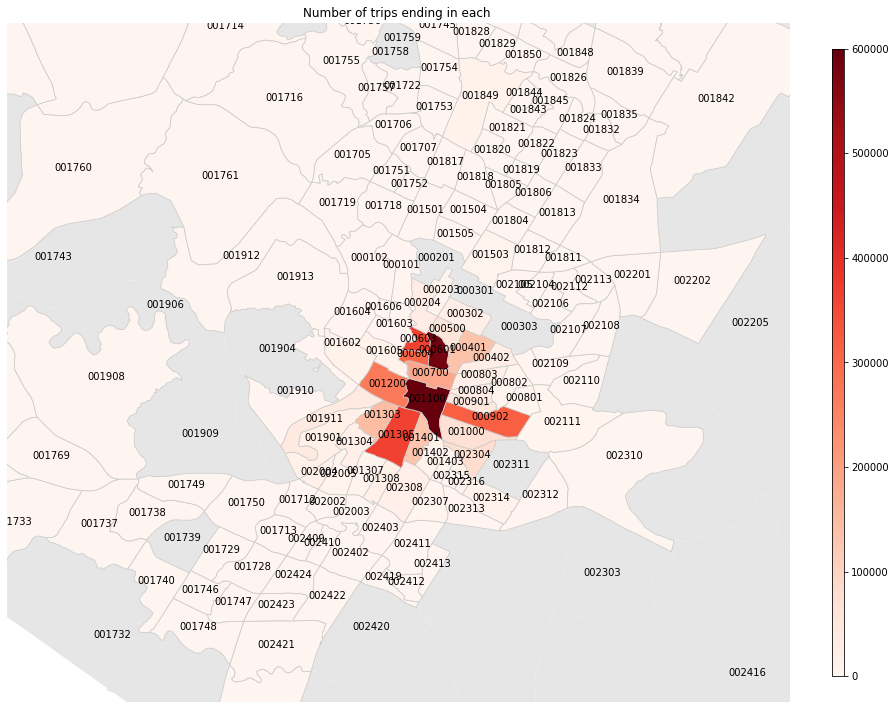

In [9]:
## Create a chloropleth of census tract starts
# Plot the data retrieved in the map
ax_start = map_df.plot(color='0.9', figsize=(15, 15))

# Merge the geodataframe with the census starts dataframe
ends_plot = map_df.set_index('CTIDFP00').join(census_ends, how='inner')

# Create a min and max for color
vmax_end = 600000
vmin_end = 0

# Overlay the census tract shapes as a chloropleth
ends_plot.plot(column='Census Tract End', cmap='Reds', linewidth=0.8, ax=ax_start, edgecolor='0.8', 
                 vmax=vmax_end, vmin=vmin_end)

# Label the census tracts
for idx, row in map_df.iterrows():
    plt.annotate(s=row['TRACTCE00'], xy=(row['INTPTLON00'], row['INTPTLAT00']), horizontalalignment='center', 
                 clip_on=True)


# Set the limits of the plot using bbox from above
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])

# Remove the axis, add title, and legend
plt.axis('off')
plt.title('Number of trips ending in each ')
sm_end = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin_end, vmax=vmax_end))
plt.colorbar(sm_end, fraction=0.015, aspect=50)

plt.show()
plt.close()

CT 1100 is the clear frontrunner with the most trips. CT 1100 is Austin's downtown district, which likely accounts for its high ridership.

## 5. Which days have the most traffic?

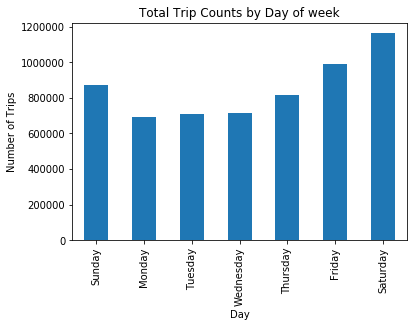

In [10]:
# Count trips per day and sort by day:
daily_total = pd.DataFrame(scooters['Day of Week'].value_counts().sort_index())

# Map day of week for better labels. Data documentation indicates "0=Sunday and so on.""
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
daily_total['Day'] = days

# Plot
daily_total.plot(kind='bar', x='Day', y='Day of Week', title='Total Trip Counts by Day of week', legend=False)
plt.ylabel('Number of Trips')
plt.show()
plt.close()

We see that general ridership is flat during the week, and increases into the weekend.  Next, we'll explore whether this trend is different for different census tracts.

## 6. Does location affect day of week traffic differently?

To determine if different location have a different ridership pattern, we start with the top 4 census tract locations.

Top 4 starting location counts by day:


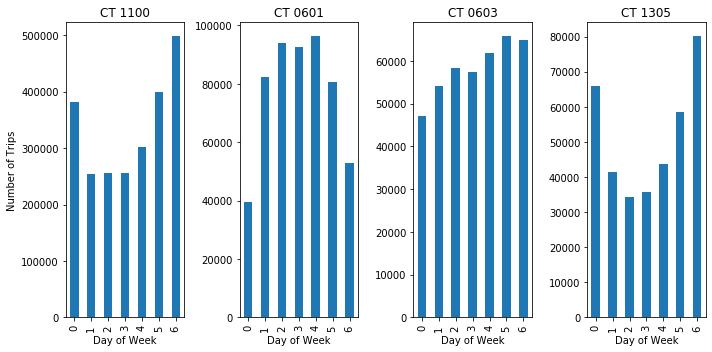

Top 4 ending location counts by day:


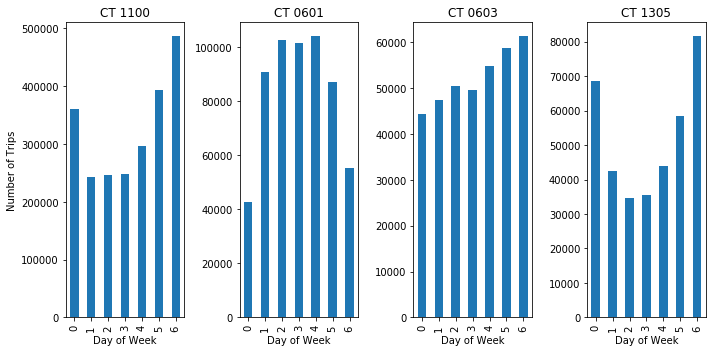

In [11]:
# Count start location by day:
weekday_start = scooters.groupby(by=['Day of Week', 'Census Tract Start']).count()

# Because the NAs are removed, the count value will be consistent throughout.  So arbitrarily use the Device ID column.
weekday_start_pivot = pd.pivot_table(weekday_start, index='Census Tract Start', values='Device ID', columns='Day of Week')

# Create plots to compare the top 4 starting locations
print('Top 4 starting location counts by day:')
plt.figure(figsize=[10, 5])

# Plot separately because the intent is to compare day to day and trends, not absolute ridership between tracts
plt.subplot(1,4,1)
weekday_start_pivot.loc['48453001100'].plot(kind='bar')
plt.title('CT 1100')
plt.ylabel('Number of Trips')

plt.subplot(1,4,2)
weekday_start_pivot.loc['48453000601'].plot(kind='bar')
plt.title('CT 0601')

plt.subplot(1,4,3)
weekday_start_pivot.loc['48453000603'].plot(kind='bar')
plt.title('CT 0603')

plt.subplot(1,4,4)
weekday_start_pivot.loc['48453001305'].plot(kind='bar')
plt.title('CT 1305')

plt.tight_layout()
plt.show()
plt.close()

# Now do the same for ending locations:
# Count end location by day:
weekday_end = scooters.groupby(by=['Day of Week', 'Census Tract End']).count()

# Because the NAs are removed, the count value will be consistent throughout each column.  So arbitrarily use the Device ID column.
weekday_end_pivot = pd.pivot_table(weekday_end, index='Census Tract End', values='Device ID', columns='Day of Week')

# Create plots to compare the top 4 ending locations
print('Top 4 ending location counts by day:')
plt.figure(figsize=[10, 5])

# Plot separately because the intent is to compare day to day and trends, not absolute ridership between tracts
plt.subplot(1,4,1)
weekday_end_pivot.loc['48453001100'].plot(kind='bar')
plt.title('CT 1100')
plt.ylabel('Number of Trips')

plt.subplot(1,4,2)
weekday_end_pivot.loc['48453000601'].plot(kind='bar')
plt.title('CT 0601')

plt.subplot(1,4,3)
weekday_end_pivot.loc['48453000603'].plot(kind='bar')
plt.title('CT 0603')

plt.subplot(1,4,4)
weekday_end_pivot.loc['48453001305'].plot(kind='bar')
plt.title('CT 1305')

plt.tight_layout()
plt.show()
plt.close()

In CT 1100, weekend usage nearly doubles weekday usage.  In CT 0601, the opposite is true. This suggests that riders in CT 0601 are commuting and riders in CT 1100 are riding to weekend activities. Some areas have more activity on weekends, others have more activity in the middle of the week.  This supports the hypothesis that day of week can be used to predict optimal scooter placement.

The ending locations appear to track with the starting locations.  Do most trips start and end in the same census tract?

## 7. How many trips start and end in different Census Tracts?

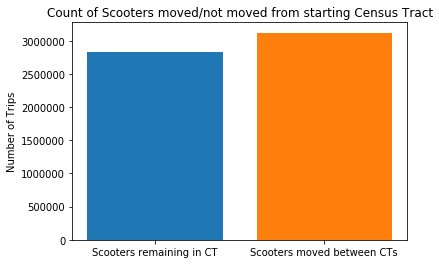

In [12]:
# Find entries where Census Tract Start and End are not equal
moved_scooters = scooters[scooters['Census Tract Start'] != scooters['Census Tract End']]
moved = moved_scooters.shape[0]

# Find entries where Census Tract Start and End are equal
stationary_scooters = scooters[scooters['Census Tract Start'] == scooters['Census Tract End']]
stationary = stationary_scooters.shape[0]

# Plot the results in a bar plot:
plt.bar('Scooters remaining in CT', moved)
plt.bar('Scooters moved between CTs', stationary)
plt.title('Count of Scooters moved/not moved from starting Census Tract')
plt.ylabel('Number of Trips')
plt.show()
plt.close()

As it turns out, more scooters are moved between Census Tracts than remain in their original Census Tract. The synchronization seen in step 6 may suggests that those tracts experience an even trade betwee scooters removed and added.

## 8. Are certain months more popular than others?

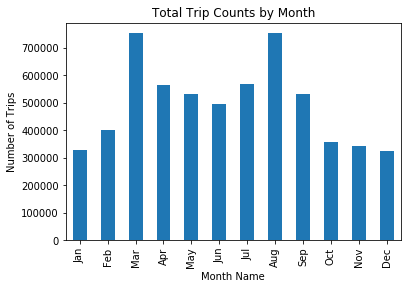

In [13]:
# Count trips per day and sort by day:
monthly_total = pd.DataFrame(scooters['Month'].value_counts().sort_index())

# Map month names for better labels.
monthly_total['Month Name'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
monthly_total.plot(kind='bar', x='Month Name', y='Month', title='Total Trip Counts by Month', legend=False)
plt.ylabel('Number of Trips')
plt.show()
plt.close()

There appears to be more ridership in the warm summer months, with peaks in temperate March and August.  However, the data only begins in early 2018, and, as we'll see in the next section, scooter popularity has increased over the last year.

## 9. How has ridership changed over time?

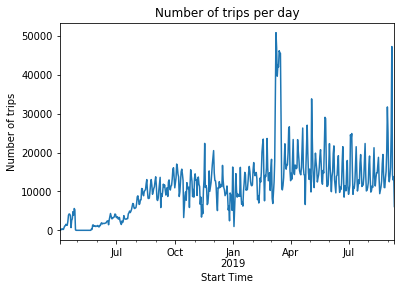

In [14]:
# Aggregate counts by day
scoots_per_day = scooters.resample('D', on='Start Time').count()

# Plot results (once again, arbitrarily using Device ID because using the count method)
scoots_per_day['Device ID'].plot()
plt.title('Number of trips per day')
plt.ylabel('Number of trips')
plt.show()
plt.close()


In mid-march of 2019, there is a peak that coincides with Austin's SXSW conference.  The regularly spaced spikes in the data appear to fall on weekends.  The graph also shows a drastic increase in late summer/early fall 2018 as scooters gained popularity accross the US.

## 10. How does time of day affect ridership?

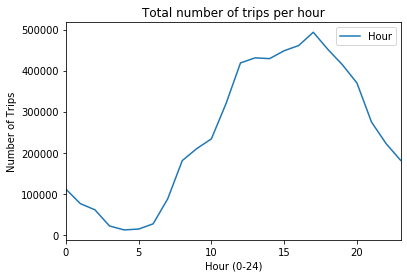

In [15]:
# Aggregate total counts by hour
scoots_per_hour = pd.DataFrame(scooters['Hour'].value_counts().sort_index())

# Plot results (once again, arbitrarily using Device ID)
scoots_per_hour.plot()
plt.title('Total number of trips per hour')
plt.xlabel('Hour (0-24)')
plt.ylabel('Number of Trips')
plt.show()
plt.close()

The majority of trips appear to occur between 10:00 AM and 7:00 PM, with a peak in the late afternoon. This might vary by day/location.

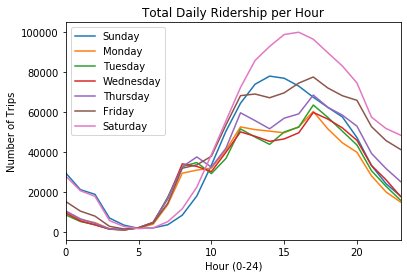

In [16]:
# Create a DataFrame grouped by Hour and day of week
scoots_hour_day = scooters.groupby(by=['Hour', 'Day of Week']).count()

# Create a pivot table with the days of the week as columns. Use the Device ID to maintain the count.
scoots_hour_day = scoots_hour_day.reset_index().pivot(index='Hour', columns='Day of Week', values='Device ID')

# Rename the columns to the verbal days of the week
scoots_hour_day.columns = days

# Plot the result
scoots_hour_day.plot()

plt.title('Total Daily Ridership per Hour')
plt.xlabel('Hour (0-24)')
plt.ylabel('Number of Trips')
plt.show()
plt.close() 
    

For each weekday, there are consistent local maxima around normal commute times: 07:00 and 17:00, with the afternoon commute appearing more popular. Then, there is a peak around noon, perhaps reflecting quick lunch trips.
On weekend days, the graphs are much smoother, with Saturday's peak at 14:00 and Sunday's at 16:00.

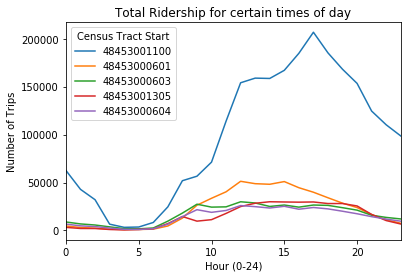

In [17]:
# Create a DataFrame grouped by Hour and day of week
scoots_hour_cts = scooters.groupby(by=['Hour', 'Census Tract Start']).count()

# Create a pivot table with the days of the week as columns. Use the Device ID to maintain the count.
scoots_hour_cts = scoots_hour_cts.reset_index().pivot(index='Hour', columns='Census Tract Start', values='Device ID')

# Plot the result for the top 5 census tracts
scoots_hour_cts[list(census_comp.head(5).index)].plot()

plt.title('Total Ridership for certain times of day')
plt.xlabel('Hour (0-24)')
plt.ylabel('Number of Trips')
plt.show()
plt.close() 

The top 5 census tracts appear to have different peak times.  This further supports the hypothesis that time of day can be used to optimize scooter placement.

## 11. What does movement between Census Tracts look like?

In [18]:
# Import centroids file, which I created from US census bureau's TIGER shapefile using QGIS.
centroids_dtypes = {'CTIDFP00': str}
centroids = pd.read_csv('ct data/centroids.csv', dtype=centroids_dtypes)
centroids.head()

# Drop unneeded columns
centroids = centroids.drop(['STATEFP00', 'COUNTYFP00', 'TRACTCE00', 'NAME00', 'NAMELSAD00', 
                            'MTFCC00', 'FUNCSTAT00', 'ALAND00', 'AWATER00'],
                          axis=1)

# Perform 1st join for start locations.  Left join because we want to keep all values in scooters 
scooters = pd.merge(scooters, centroids, how='left', left_on='Census Tract Start', 
                    right_on='CTIDFP00', copy=False)
scooters = scooters.drop('CTIDFP00', axis=1)

# Rename columns
scooters = scooters.rename(columns={'INTPTLAT00': 'start_lat', 'INTPTLON00': 'start_long'}, 
                           copy=False)


# Perform 2nd join for end locations. Also a left join
scooters = pd.merge(scooters, centroids, how='left', left_on='Census Tract End', 
                    right_on='CTIDFP00', copy=False)
scooters = scooters.drop('CTIDFP00', axis=1)

# Rename columns
scooters = scooters.rename(columns={'INTPTLAT00': 'end_lat', 'INTPTLON00': 'end_long'}, 
                           copy=False)

To revisit movement between census tracts, I developed the function below to generate plots of any census tract.  Once again the top 4 are used below

In [19]:
# Create a function that will plot trips from each census tract
def plot_trips(df, census_tract, bbox, color='b', vmin_trips=0, vmax_quantile=0.75, linewidth=3):
    '''
    Function that plots all of the trips that originated in the specified census tract.
    Keyword Arguments
    ------------------
    df : DataFrame
        Source dataframe
    census_tract : str
        11-digit census tract number
    color : str
        Matplotlib colormap code
    bbox : list or array (optional)
        Bounding box of the desired map extents
    vmin_trips: int (optional)
        Minimum number of trips for color display (default 0)
    vmax_quantile: float from 0 to 1
        Maximum quantile to use for color display.
    linewidth: float or int (optional)
        linewidth for plotting
    '''

    # Create a dataframe from the desired census tract
    lines = df.loc[df['Census Tract Start'] == census_tract][['Census Tract Start', 'Census Tract End', 'start_lat', 'start_long', 
                  'end_lat', 'end_long']].copy()

    # Count the census tract ends
    line_vals = pd.DataFrame(lines['Census Tract End'].value_counts())
    
    # Rename the values columns
    line_vals.columns = ['CT End Count']

    # Merge the line vals with 
    line_intensity = pd.merge(pd.DataFrame(line_vals), lines, how='inner', left_index=True, right_on='Census Tract End')

    # Drop duplicates
    line_intensity = line_intensity.drop_duplicates()
    
    # Convert the lat/long data in the dataframe to linestrings
    line_intensity['geometry'] = line_intensity.apply(lambda x: LineString([(x['start_long'], x['start_lat']) , 
                                                      (x['end_long'], x['end_lat'])]), axis = 1)

    # Create the geopandas geodataframe.
    line_intensity = gpd.GeoDataFrame(line_intensity, geometry='geometry')
    
    # Plot the base map
    ax_trips = map_df.plot(color='0.9', figsize=(15, 15), edgecolor='0')

    # Set the extents using bbox from section 4
    plt.xlim(bbox[0], bbox[1])
    plt.ylim(bbox[2], bbox[3])

    # Resort so that smallest CT End Counts are plotted first
    line_intensity = line_intensity.sort_values(by='CT End Count')
    
    # Set vmax to limit the max color to the vmax_quantile 
    vmax_trips = line_intensity['CT End Count'].quantile(vmax_quantile)
  
    # Plot the lines
    line_intensity.plot(column='CT End Count', 
                        cmap=color, 
                        linewidth=linewidth, 
                        ax = ax_trips, 
                        vmin = vmin_trips, 
                        vmax = vmax_trips)
    
    # Add a color bar
    sm_trips = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin_trips, vmax=vmax_trips))
    plt.colorbar(sm_trips, fraction=0.015, aspect=50, 
                 label='Number of trips (maximum includes values shown and above)')

    # Add a title and show
    plt.title('Trips originating in' + census_tract)
    
    # Remove axes
    plt.axis('off')
    

    plt.show()
    plt.close()


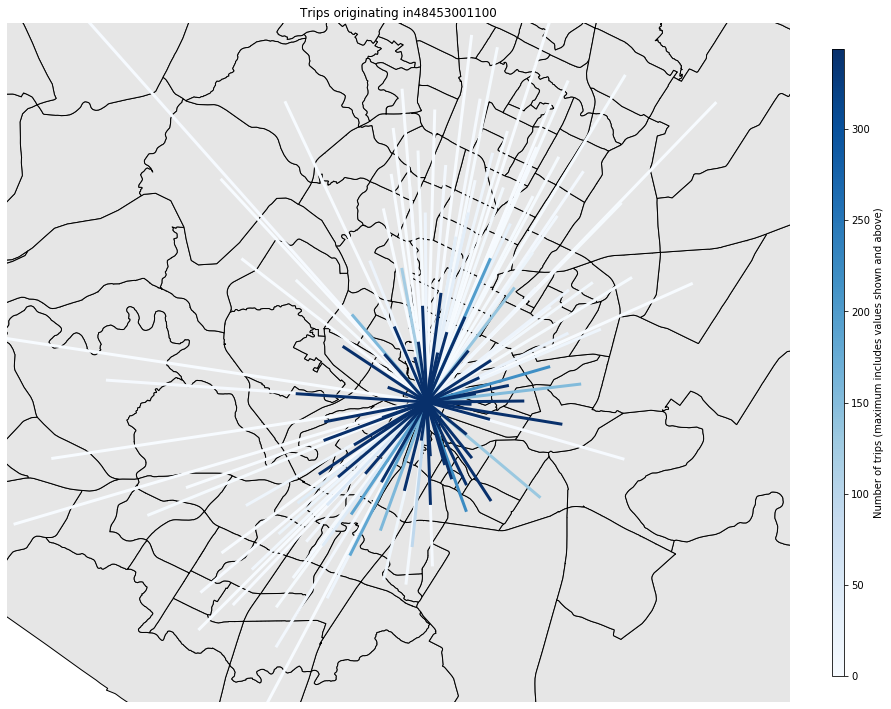

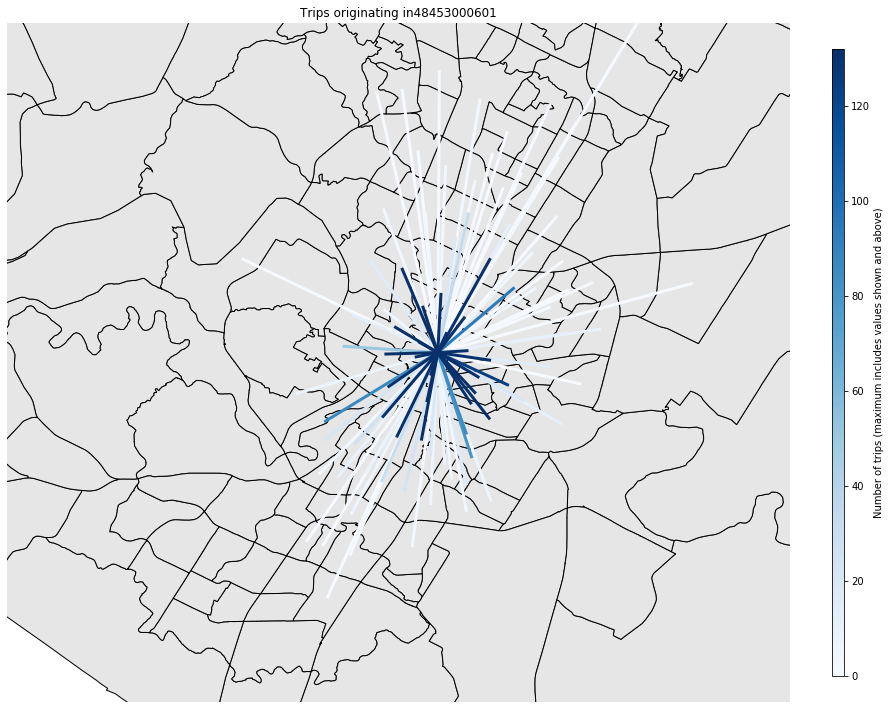

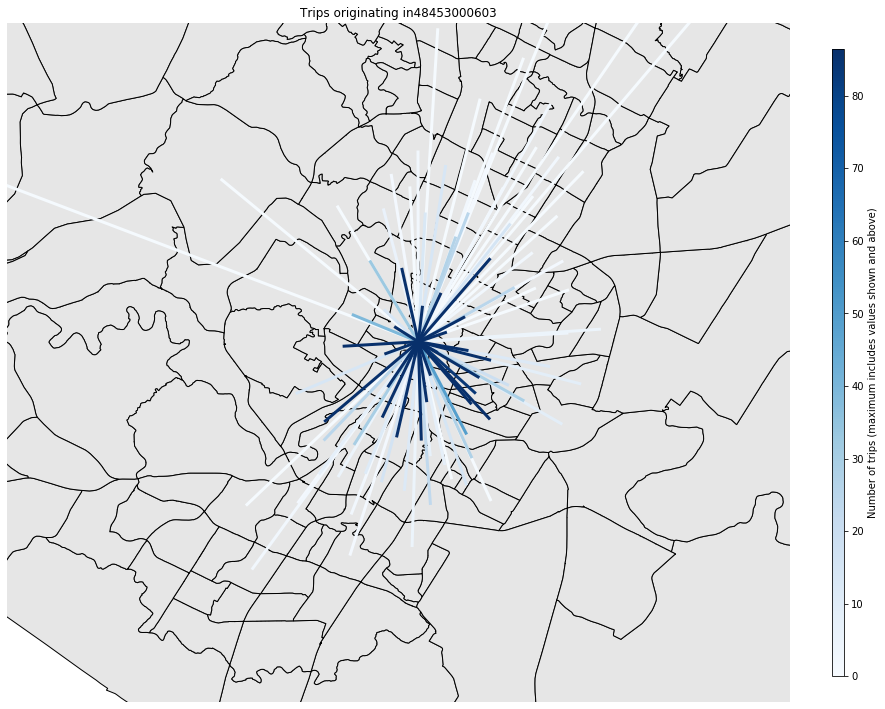

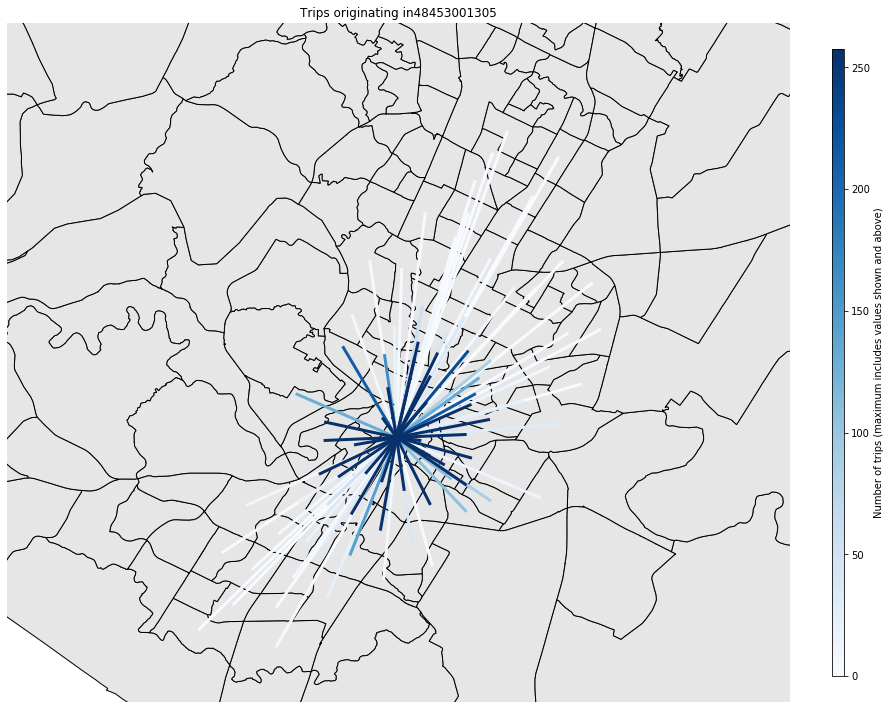

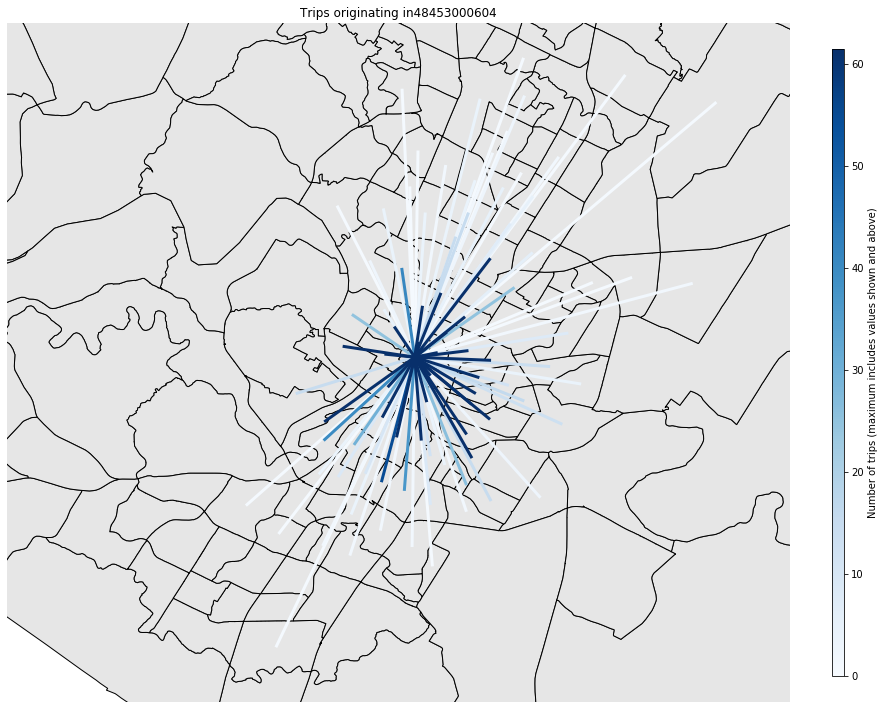

In [20]:
# Create plots of the top 4 census tracts
for i, val in census_starts.head().iterrows():
     plot_trips(scooters, i, bbox=bbox, color='Blues')

These plots are primarly focused on the city center.  Looking at the color intensity, the highest number of trips are only 1 or two census tracts away from the census tract start.

## 12. Conclusion
The data shows that location, date, week, and time of day have a significant impact on the ridership numbers.  These variables appear to be great options for creating a model to predict scooter ridership in an area.